In [20]:
import descarga_tratamiento
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Selección del partido para descargar

In [14]:
"""
LIGAS DISPONIBLES

LaLiga (ESP)
PremierLeague (ING)
SerieA  (ITA)
Bundesliga  (ALE)
Ligue1  (FRA)
"""
dicc_ligas = {'ESP': 'La_liga',
              'ING': 'EPL',
              'ITA': 'Serie_A',
              'ALE': 'Bundesliga',
              'FRA': 'Ligue_1'}

In [15]:
# Para descargar un partido de La Liga 
while True:
    liga = str(input('¿Qué Liga es?: ')).upper()    #ESP
    if liga in dicc_ligas:
        break
    else:
        print('Introduce una liga disponible')
temporada = str(input('¿Qué temporada es?: '))  #23-24
jornada = str(input('¿Qué jornada es?: '))  #37

In [16]:
# ID Almería - Getafe de la jornada 33 -> 23005
# ID Villarreal - Real Madrid de la jornada 37 - > 23054

# ID del partido del que se quieren obtener los datos
partido = str(input('¿Cuál es el ID del partido que quieres descargar: '))
enlace = 'https://understat.com/match/' + partido   # Enlace del partido elegido

# Descarga y tratamiento de los tiros del partido

In [17]:
datos = descarga_tratamiento.obtener_datos_partido(enlace)  # Llamada a la función para obtener el diccionario con los tiros del partido
datos

{'h': [{'id': '582388',
   'minute': '5',
   'result': 'MissedShots',
   'X': '0.8530000305175781',
   'Y': '0.590999984741211',
   'xG': '0.07621308416128159',
   'player': 'Alberto Moreno',
   'h_a': 'h',
   'player_id': '608',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'LeftFoot',
   'match_id': '23054',
   'h_team': 'Villarreal',
   'a_team': 'Real Madrid',
   'h_goals': '4',
   'a_goals': '4',
   'date': '2024-05-19 17:00:00',
   'player_assisted': 'Alexander Sørloth',
   'lastAction': 'Pass'},
  {'id': '582389',
   'minute': '5',
   'result': 'ShotOnPost',
   'X': '0.7190000152587891',
   'Y': '0.4159999847412109',
   'xG': '0.01734926924109459',
   'player': 'Alexander Sørloth',
   'h_a': 'h',
   'player_id': '6531',
   'situation': 'OpenPlay',
   'season': '2023',
   'shotType': 'LeftFoot',
   'match_id': '23054',
   'h_team': 'Villarreal',
   'a_team': 'Real Madrid',
   'h_goals': '4',
   'a_goals': '4',
   'date': '2024-05-19 17:00:00',
   'player_assiste

In [18]:
# Llamada a la función para realizar el tratamiento y guardar el resultado en un Excel
df_tiros = descarga_tratamiento.traducir_tiros(datos, dicc_ligas, liga, jornada, temporada)
df_tiros.to_excel("ESP_37_23-24_Villarreal-Real_Madrid_tiros.xlsx", index=False)
df_tiros

,jugador,equipo,minuto,xg,zona_contacto,resultado,x,y,situacion,asistente,accion_anterior,id,partido
0,Alberto Moreno,Villarreal,5,0.076213,Pierna izquierda,Tiro fuera,0.8530000305175781,0.590999984741211,Juego abierto,Alexander Sørloth,Pase,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
1,Alexander Sørloth,Villarreal,5,0.017349,Pierna izquierda,Tiro al palo,0.7190000152587891,0.4159999847412109,Juego abierto,Santiago Comesaña,Pase,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
2,Ilias Akhomach,Villarreal,9,0.03301,Pierna derecha,Tiro bloqueado,0.8830000305175781,0.285,Juego abierto,Gerard Moreno,Pase,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
3,Gonçalo Guedes,Villarreal,9,0.041867,Pierna derecha,Tiro bloqueado,0.785,0.5279999923706055,Juego abierto,None,Perdida,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
4,Santiago Comesaña,Villarreal,17,0.019931,Cabeza,Tiro a porteria,0.88,0.38299999237060545,Juego abierto,Alberto Moreno,Centro,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
5,Ilias Akhomach,Villarreal,19,0.02654,Pierna izquierda,Tiro fuera,0.8480000305175781,0.255,Juego abierto,Daniel Parejo,Pase,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
6,Gonçalo Guedes,Villarreal,22,0.067349,Pierna derecha,Tiro bloqueado,0.8490000152587891,0.5990000152587891,Juego abierto,Alberto Moreno,Pase,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
7,Yerson Mosquera,Villarreal,22,0.121804,Cabeza,Tiro a porteria,0.9519999694824218,0.5670000076293945,Remate de corner,Daniel Parejo,Centro,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
8,Alexander Sørloth,Villarreal,38,0.096301,Cabeza,Gol,0.904000015258789,0.51,Juego abierto,Yerson Mosquera,Centro,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid
9,Santiago Comesaña,Villarreal,42,0.064471,Cabeza,Tiro fuera,0.914000015258789,0.475,Juego abierto,Gonçalo Guedes,Aereo,La_liga_37_23-24_Villarreal-Real Madrid,Villarreal-Real Madrid


# Visualización de la evolución de los xG en el partido

In [9]:
# Leer el archivo Excel con los tiros del partido
#df_tiros = pd.read_excel("ESP_33_23-24_Almeria-Getafe_tiros.xlsx")
df_tiros = pd.read_excel("ESP_37_23-24_Villarreal-Real_Madrid_tiros.xlsx")

In [11]:
def lista_acumulados(lista):   # Función que devuelve una lista con la suma de los valores acumulados de la lista recibida
    return [sum(lista[: i + 1]) for i in range(len(lista))]

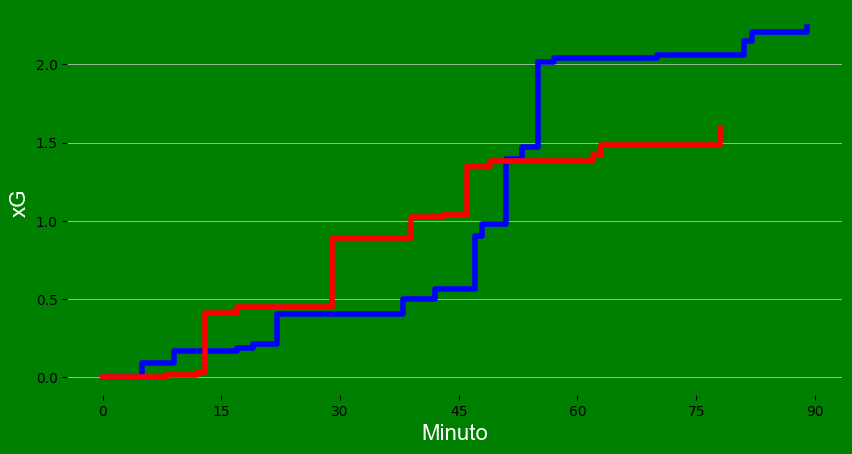

In [12]:
# Listas para los valores que se quieren representar en el gráfico
xg_local = [0]
xg_visitante= [0]
minuto_local = [0]
minuto_vistante = [0]
equipo_local = df_tiros['equipo'].iloc[0]   # Obtener el nombre del equipo local y del visitante
equipo_visitante = df_tiros['equipo'].iloc[-1]
for i in range(len(df_tiros.index)):    # Añadir los valores del dataframe a las listas correspondientes
    if df_tiros['equipo'][i] == equipo_local:
        xg_local.append(df_tiros['xg'][i])
        minuto_local.append(df_tiros['minuto'][i])
    else:
        xg_visitante.append(df_tiros['xg'][i])
        minuto_vistante.append(df_tiros['minuto'][i])
xg_local_total = lista_acumulados(xg_local) # Llamada a la función que calcula la lista acumulada
xg_visitante_total = lista_acumulados(xg_visitante)
max_xg_local = round(xg_local_total[-1], 2) # Redondear a dos decimales el valor máximo de xG
max_xg_visitante = round(xg_visitante_total[-1], 2)
# Comienzo del diseño del gráfico
fig, ax = plt.subplots(figsize = (10, 5))    # Determinar el tamaño y el color del gráfico
fig.set_facecolor('green')
ax.patch.set_facecolor('green')
ax.grid(lw=.5, color='lightgrey', axis='y', zorder=1)   # Añadir una grilla en el eje y
#ax.grid(lw=.5, color='lightgrey', axis='x', zorder=1)
limites = ['right', 'bottom', 'left', 'top']
for i in limites:
    if i in limites:
        ax.spines[i].set_visible(False)    # Desactivar los límites del gráfico
plt.xticks([0, 15, 30, 45, 60, 75, 90]) # Determinar el intervalo del eje x 
# Dar un nombre a los ejes
plt.xlabel('Minuto', fontname='Arial', color='white', fontsize=16)
plt.ylabel('xG', fontname='Arial', color='white', fontsize=16)  
# Añadir las líneas de la evolución de xG de cada equipo
ax.step(x=minuto_local, y=xg_local_total, color='blue', label=equipo_local, linewidth=4, where='post') 
ax.step(x=minuto_vistante, y=xg_visitante_total, color='red', label=equipo_visitante, linewidth=4, where='post')
plt.savefig("xg_partido.jpg")